# Better optimizer for image generation

This notebook is based on neural-style.ipynb plus one key observation: the L-BFGS-B optimization algorithm used always gets stuck in local minima, and the local minima seems to always have a characteristic pattern of artifacts with a high spatial frequency in the generated image.  Can we suppress those artifacts by simple blurring?

## Setup - same as original notebook

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
limit_mem()

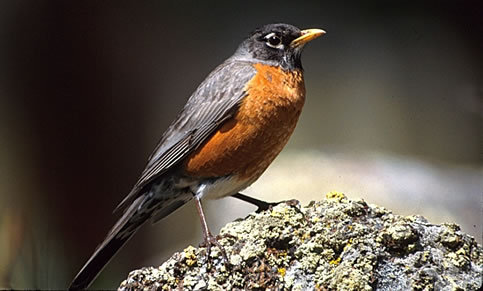

In [3]:
img = Image.open('/home/ubuntu/www.platform.ai/data/imagenet-sample-train/train/n01558993/n01558993_9684.JPEG'); img

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [5]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [6]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
model = VGG16_Avg(include_top=False)

In [8]:
layer = model.get_layer('block5_conv1').output

In [9]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In [10]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [11]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

## Modified code after this point

Let's see if it's possible to recreate the input image from the block5_conv1 activations, but with a twist: blur the image whenever the optimizer gets stuck.

First, a function that blurs an image in-place (channel by channel) using simple gaussian blur with sigma = 1

In [113]:
import scipy.ndimage.filters

def blurify(x):
    x = x.reshape(shp)
    for k in range(3):
        x[:,:,:,k] = scipy.ndimage.filters.gaussian_filter(x[:,:,:,k], 1)
    return x

Then, modify solve_image to detect when a local minimum has been reached (very small change per step < 0.001), and blur the image then continue.  This may need to be tuned, it is possible that it detects local minima somewhat too early (could try change per step < 0.0001 instead).

In [12]:
def solve_image(eval_obj, niter, x):
    last_min_val = 1000 # Start from some arbitrary very high number # TODO init with None
    loss_history = {}
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Iter: %d  Loss: %f' %(i, min_val))
        if abs(last_min_val - min_val) < 0.001:
            x = blurify(x)
            print('Blurify')
        last_min_val = min_val
        loss_history[i] = min_val
        imsave('/home/ubuntu/results/res_at_iteration_%d.png' %(i), (deproc(x.copy(), shp)[0]))
    return x, loss_history

Start from all zeros.  Noise vs all zeros doesn't seem to make any difference in practice...

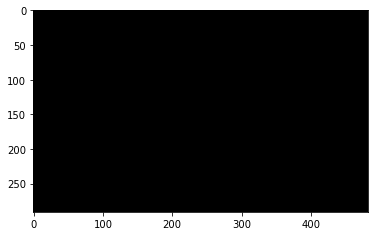

In [13]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
# x = rand_img(shp)
x = np.zeros(shp)
plt.imshow(x[0]);

Run for a ridiculous number of iterations

In [21]:
iterations=1000

In [116]:
x, loss_history = solve_image(evaluator, iterations, x)

Iter: 0  Loss: 56.332458
Iter: 1  Loss: 21.307999
Iter: 2  Loss: 11.739264
Iter: 3  Loss: 8.211292
Iter: 4  Loss: 6.507470
Iter: 5  Loss: 5.483242
Iter: 6  Loss: 4.860817
Iter: 7  Loss: 4.388783
Iter: 8  Loss: 3.996233
Iter: 9  Loss: 3.699281
Iter: 10  Loss: 3.469527
Iter: 11  Loss: 3.264268
Iter: 12  Loss: 3.202618
Iter: 13  Loss: 3.190215
Iter: 14  Loss: 3.190377
Blurify
Iter: 15  Loss: 5.273498
Iter: 16  Loss: 3.830165
Iter: 17  Loss: 3.301814
Iter: 18  Loss: 2.958852
Iter: 19  Loss: 2.727372
Iter: 20  Loss: 2.563292
Iter: 21  Loss: 2.436050
Iter: 22  Loss: 2.337002
Iter: 23  Loss: 2.315290
Iter: 24  Loss: 2.316147
Blurify
Iter: 25  Loss: 3.951824
Iter: 26  Loss: 2.967965
Iter: 27  Loss: 2.604438
Iter: 28  Loss: 2.388319
Iter: 29  Loss: 2.237290
Iter: 30  Loss: 2.131394
Iter: 31  Loss: 2.109755
Iter: 32  Loss: 2.108187
Iter: 33  Loss: 2.108195
Blurify
Iter: 34  Loss: 3.451382
Iter: 35  Loss: 2.599714
Iter: 36  Loss: 2.289659
Iter: 37  Loss: 2.129872
Iter: 38  Loss: 2.020915
Iter: 39

As it turns out, the fmin_l_bfgs_b optimizer used in the original gets stuck in a local minimum in approximately 13-15 iterations, with a loss of 3.19.  It does not seem to move from there regardless of how many more iterations it is run for.

This is what the image looks like at that point:

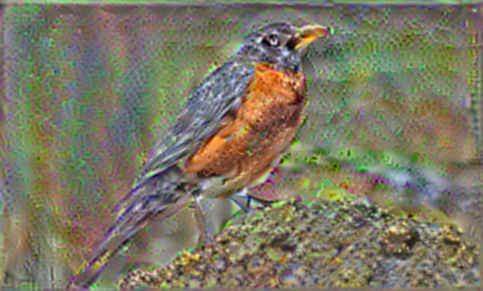

In [17]:
Image.open('/home/ubuntu/results/res_at_iteration_14.png')

If the image is blurred whenever the loss stops improving, after 994 iterations the loss reaches 0.53.  The image looks like this:

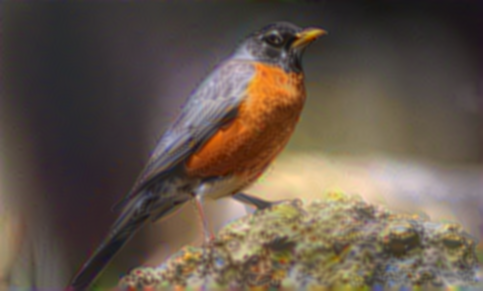

In [15]:
Image.open('/home/ubuntu/results/res_at_iteration_994.png')

The original image, for comparison:

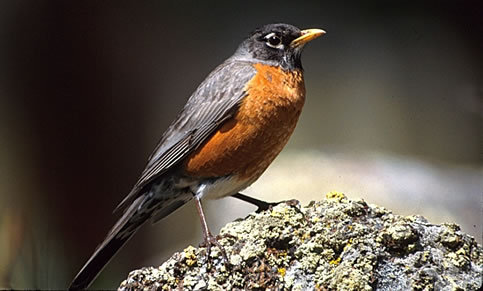

In [16]:
img

The loss history shows a pattern of going up by roughly 0.5 after each blur, then quickly dropping into another local minimum.  Not every local minimum is better than the previous one, but over time there is a definite downward trend...

(0, 1000)

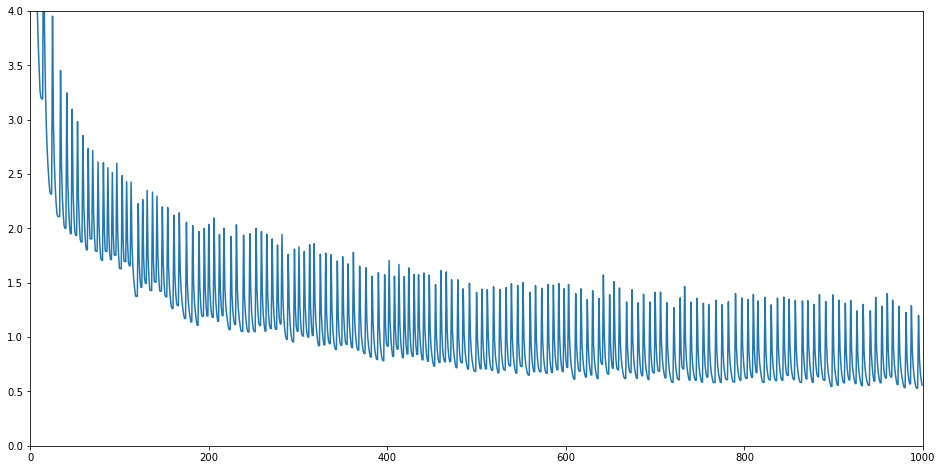

In [31]:
plt.figure(figsize=(16,8))
plt.plot([loss_history[i] for i in range(iterations)])
plt.ylim((0, 4))
plt.xlim((0, 1000))

It is quite likely that even after 1000 iterations this is not fully converged.

## Why this works

Here are some possible reasons why this works:

We can suppose that realistic images form a manifold in the space of all images.  One of the key properties of that manifold is that nearby pixels are highly correlated: edges are rare.  The optimizer (BFGS in this case, but that is likely not specific to the choice of optimizer) is unaware of this, and moves in the direction of the local gradient which in general is away from the manifold.  Once the image starts being sufficiently different in type (or pixel-pixel correlation statistics) from a natural image, the gradient of the image wrt the feaure map that the network produces stops being useful, and it falls into a (likely shallow) local minimum.

Instead, we want to move along the manifold.  In this case, we keep moving the image back to the manifold whenever it has diverged, by essentially forcing a correlation between nearby pixels by brute force ie blurring.  However, it should also be possible to add a loss term that corresponds to the correlation of pairs of pixels vs their distance, or (to keep things simple) just the correlation of nearest-neighbor pixels.

## Future directions

- Use this for style transfer, not just to recreate input image

- Modify the loss by adding a pixel-pixel correlation term, or nearest-neighbor correlation term, and see if we can prevent local minima entirely

- Figure out how long it takes for this to fully converge...

- Try different sigma values.  Sigma=1 is likely not optimal, it just kind of works

- Try blurring more often, perhaps a slight blur at every step without waiting for BFGS to converge